In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

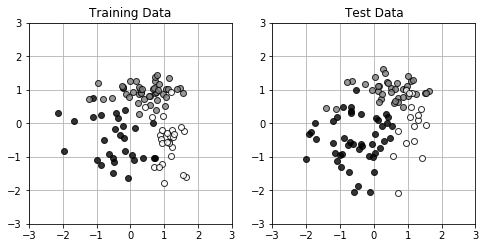

In [3]:
outfile = np.load('class_data.npz')
np.random.seed(seed=1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]

X_train=outfile['X_train']        
X_test=outfile['X_test']
X_range0=outfile['X_range0']
X_range1=outfile['X_range1']
T_train=outfile['T_train']        
T_test=outfile['T_test']

        
def show_data(x,t):
    wk,n=t.shape
    c=[[0,0,0],[.5,.5,.5],[1,1,1]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],linestyle='none',marker='o',markeredgecolor='black',color=c[i],alpha=0.8)
        plt.grid(True)
plt.figure(1,figsize=(8,3.7))
plt.subplot(1,2,1)
show_data(X_train,T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1,2,2)
show_data(X_test,T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [4]:
def Sigmoid(x):
    y=1/(1+np.exp(-x))
    return y
def FNN(wv,M,K,x):
    N,D=x.shape
    w=wv[:M*(D+1)]
    w=w.reshape(M,(D+1))
    v=wv[M*(D+1):]
    v=v.reshape(K,(M+1))
    b=np.zeros((N,M+1))
    z=np.zeros((N,M+1))
    a=np.zeros((N,K))
    y=np.zeros((N,K))
    for n in range(N):
        for m in range(M):
            b[n,m]=np.dot(w[m,:],np.r_[x[n,:],1])
            z[n,m]=Sigmoid(b[n,m])
        z[n,M]=1
        wkz=0
        for k in range(K):
            a[n,k]=np.dot(v[k,:],z[n,:])
            wkz=wkz+np.exp(a[n,k])
        for k in range(K):
            y[n,k]=np.exp(a[n,k])/wkz
    return y,a,z,b

WV=np.ones(15)
M=2
K=3
FNN(WV,M,K,X_train[:2,:])
        

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


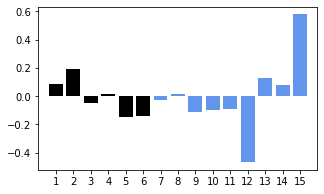

In [5]:
def CE_FNN(wv,M,K,x,t):
    N,D=x.shape
    y,a,z,b=FNN(wv,M,K,x)
    ce=-np.dot(np.log(y.reshape(-1)),t.reshape(-1))/N
    return ce
CE_FNN(WV,M,K,X_train[:2,:],T_train[:2,:])

def dCE_FNN_num(wv,M,K,x,t):
    epsilon=0.001
    dwv=np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified=wv.copy()
        wv_modified[iwv]=wv[iwv]-epsilon
        mse1=CE_FNN(wv_modified,M,K,x,t)
        wv_modified[iwv]=wv[iwv]+epsilon
        mse2=CE_FNN(wv_modified,M,K,x,t)
        dwv[iwv]=(mse2-mse1)/(2*epsilon)
    return dwv
def show_WV(wv,M):
    N=wv.shape[0]
    plt.bar(range(1,M*3+1),wv[:M*3],align='center',color='black')
    plt.bar(range(M*3+1,N+1),wv[M*3:],align='center',color='cornflowerblue')
    plt.xticks(range(1,N+1))
    plt.xlim(0,N+1)
    
nWV=M*3+K*(M+1)
np.random.seed(1)
WV=np.random.normal(0,1,nWV)
dWV=dCE_FNN_num(WV,M,K,X_train[:2,:],T_train[:2,:])
print(dWV)
plt.figure(1,figsize=(5,3))
show_WV(dWV,M)
plt.show()

In [6]:
import time

def Fit_FNN_num(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):
    wvt=wv_init
    err_train=np.zeros(n)
    err_test=np.zeros(n)
    wv_hist=np.zeros((n,len(wv_init)))
    epsilon=0.001
    for i in range(n):
        wvt=wvt-alpha*dCE_FNN_num(wvt,M,K,x_train,t_train)
        err_train[i]=CE_FNN(wvt,M,K,x_train,t_train)
        err_test[i]=CE_FNN(wvt,M,K,x_test,t_test)
        wv_hist[i,:]=wvt
    return wvt,wv_hist,err_train,err_test

startTime=time.time()
M=2
K=3
np.random.seed(1)
WV_init=np.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000
alpha=0.5
WV,WV_hist,Err_train,Err_test=Fit_FNN_num(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)
caculation_time=time.time()-startTime
print("Caculation time:{0:.3f}sec".format(caculation_time))

Caculation time:374.465sec


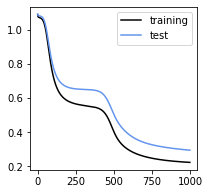

In [7]:
plt.figure(1,figsize=(3,3))
plt.plot(Err_train,'black',label='training')
plt.plot(Err_test,'cornflowerblue',label='test')
plt.legend()
plt.show()

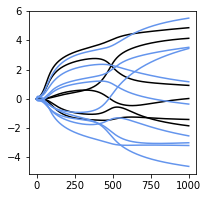

In [8]:
plt.figure(1,figsize=(3,3))
plt.plot(WV_hist[:,:M*3],'black')
plt.plot(WV_hist[:,M*3:],'cornflowerblue')
plt.show()

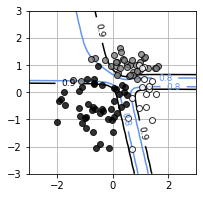

In [9]:
def show_FNN(wv,M,K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, order='F'), np.reshape(xx1, xn * xn, order='F')]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    
plt.figure(1, figsize=(3, 3))
show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

In [10]:
def dCE_FNN(wv,M,K,x,t):
    N,D=x.shape
    w=wv[:M*(D+1)]
    w=w.reshape(M,(D+1))
    v=wv[M*(D+1):]
    v=v.reshape(K,M+1)
    y,a,z,b=FNN(wv,M,K,x)
    dwv=np.zeros_like(wv)
    dw=np.zeros((M,D+1))
    dv=np.zeros((K,M+1))
    delta1=np.zeros(M)
    delta2=np.zeros(K)
    for n in range(N):
        for k in range(K):
            delta2[k]=(y[n,k]-t[n,k])
        for j in range(M):
            delta1[j]=z[n,j]*(1-z[n,j])*np.dot(v[:,j],delta2)
        for k in range(K):
            dv[k,:]=dv[k,:]+delta2[k]*z[n,:] / N
        for j in range(M):
            dw[j,:]=dw[j,:]+delta1[j]*np.r_[x[n,:],1] / N
    dwv=np.c_[dw.reshape((1,M*(D+1))),dv.reshape((1,K*(M+1)))]
    dwv=dwv.reshape(-1)
    return dwv

def show_dWV(wv,M):
    N=wv.shape[0]
    plt.bar(range(1,M*3+1),wv[:M*3],align='center',color='black')
    plt.bar(range(M*3+1,N+1),wv[M*3:],align='center',color='cornflowerblue')
    plt.xticks(range(1,N+1))
    plt.xlim(0,N+1)

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


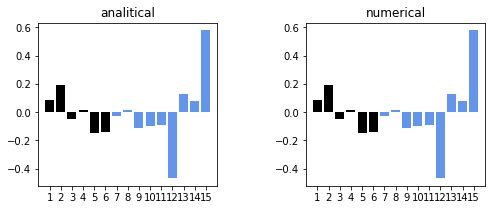

In [11]:
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)


dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)


plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [12]:
import time

def Fit_FNN(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):
    wv=wv_init.copy()
    err_train=np.zeros(n)
    err_test=np.zeros(n)
    wv_hist=np.zeros((n,len(wv_init)))
    epsilon=0.001
    for i in range(n):
        wv=wv-alpha*dCE_FNN(wv,M,K,x_train,t_train)
        err_train[i]=CE_FNN(wv,M,K,x_train,t_train)
        err_test[i]=CE_FNN(wv,M,K,x_test,t_test)
        wv_hist[i,:]=wv
    return wv,wv_hist,err_train,err_test

startTime=time.time()
M=2
K=3
np.random.seed(1)
WV_init=np.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000
alpha=0.5
WV,WV_hist,Err_train,Err_test=Fit_FNN(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)
caculation_time=time.time()-startTime
print("Caculation time:{0:.3f}sec".format(caculation_time))

Caculation time:48.490sec


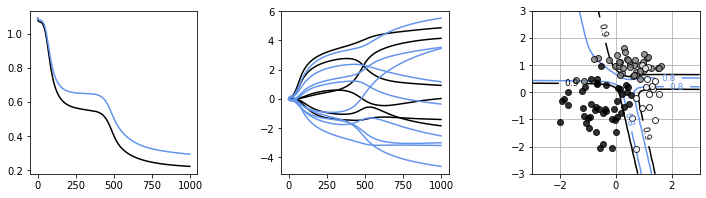

In [13]:
plt.figure(1,figsize=(12,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,3,1)
plt.plot(Err_train,'black',label='training')
plt.plot(Err_test,'cornflowerblue',label='test')
plt.legend
plt.subplot(1,3,2)
plt.plot(WV_hist[:,:M*3],'black')
plt.plot(WV_hist[:,M*3:],'cornflowerblue')
plt.subplot(1,3,3)
show_data(X_test,T_test)
show_FNN(WV,M,K)
plt.show()

In [71]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation

In [77]:
outfile=np.load('class_data.npz')
X_train=outfile['X_train']        
X_test=outfile['X_test']
X_range0=outfile['X_range0']
X_range1=outfile['X_range1']
T_train=outfile['T_train']        
T_test=outfile['T_test']



def Show_data(x,t):
    wk,n=t.shape
    c=[[0,0,0],[.5,.5,.5],[1,1,1]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],linestyle='none',marker='o',markeredgecolor='black',color=c[i],alpha=0.8)
    plt.grid(True)


In [79]:
np.random.seed(1)


# --- Sequential 모델 작성
model = Sequential()
model.add(Dense(2, input_dim=2, activation='sigmoid',
                kernel_initializer='uniform')) # (A)
model.add(Dense(3,activation='softmax',
                kernel_initializer='uniform')) # (B)
sgd = keras.optimizers.SGD(lr=1, momentum=0.0,
                           decay=0.0, nesterov=False) # (C)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy']) # (D)


# ---------- 학습
startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,
                    verbose=0, validation_data=(X_test, T_test)) # (E)


# ---------- 모델 평가
score = model.evaluate(X_test, T_test, verbose=0) # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'\
      .format(score[0], score[1]))
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:38.176 sec


ValueError: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead

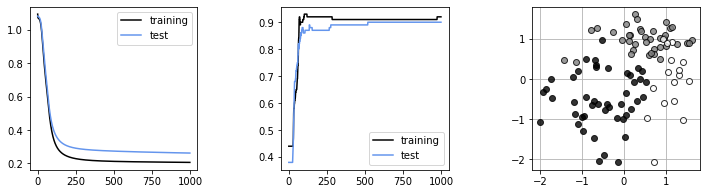

In [83]:
# 리스트 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace=0.5)


# 학습 곡선 표시 --------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') # (B)
plt.legend()


# 정확도 표시 --------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label='training') # (C)
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='test') # (D)
plt.legend()


# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y = model.predict(x) # (E)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=[
        'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()

In [1]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

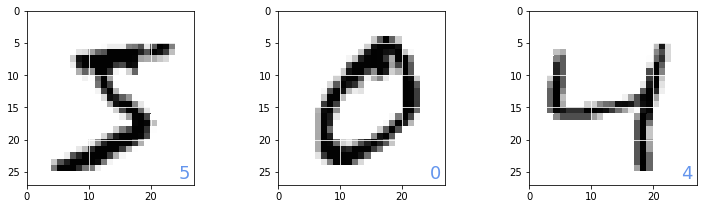

In [3]:
plt.figure(1,figsize=(12,3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
for id in range(3):
    plt.subplot(1,3,id+1)
    img=x_train[id,:,:]
    plt.pcolor(255 - img)
    plt.text(24.5,26,"%d"%y_train[id],color='cornflowerblue',fontsize=18)
    plt.xlim(0,27)
    plt.ylim(27,0)
    plt.grid('on',color='white')
plt.show()

In [4]:
from keras.utils import np_utils


x_train = x_train.reshape(60000, 784) 
x_train = x_train.astype('float32') 
x_train = x_train / 255 
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)


x_test = x_test.reshape(10000, 784)
x_test = x_test.astype('float32')
x_test = x_test / 255
y_test = np_utils.to_categorical(y_test, num_classes)

In [5]:

np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


model = Sequential() 
model.add(Dense(16, input_dim=784, activation='sigmoid')) 
model.add(Dense(10, activation='softmax')) 
model.compile(loss='categorical_crossentropy',
optimizer=Adam(), metrics=['accuracy']) 

In [6]:
model=Sequential()
model.add(Dense(16,input_dim=784,activation='sigmoid'))
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [7]:
import time

startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000,verbose=1, validation_data=(x_test, y_test)) 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/10
60/60 [==============================] - 1s 11ms/step - loss: 2.0364 - accuracy: 0.3598 - val_loss: 1.7471 - val_accuracy: 0.5765
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5954 - accuracy: 0.6697 - val_loss: 1.4340 - val_accuracy: 0.7309
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.3297 - accuracy: 0.7665 - val_loss: 1.2031 - val_accuracy: 0.8129
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1231 - accuracy: 0.8224 - val_loss: 1.0197 - val_accuracy: 0.8459
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.9601 - accuracy: 0.8450 - val_loss: 0.8775 - val_accuracy: 0.8613
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.8355 - accuracy: 0.8582 - val_loss: 0.7693 - val_accuracy: 0.8734
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.7404 - accuracy: 0.8674 - val_loss: 0.6868 - val_accuracy: 0.8809
Epoch 8/10
60/60 [=

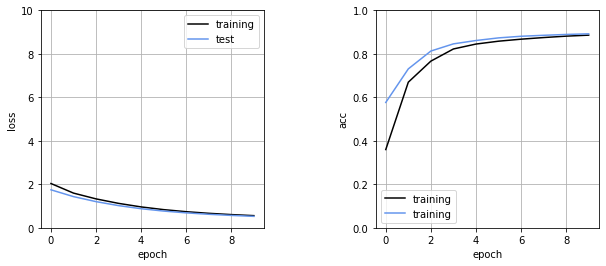

In [8]:
plt.figure(1,figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training',color='black')
plt.plot(history.history['val_loss'],label='test',color='cornflowerblue')
plt.ylim(0,10)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='training',color='black')
plt.plot(history.history['val_accuracy'],label='training',color='cornflowerblue')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

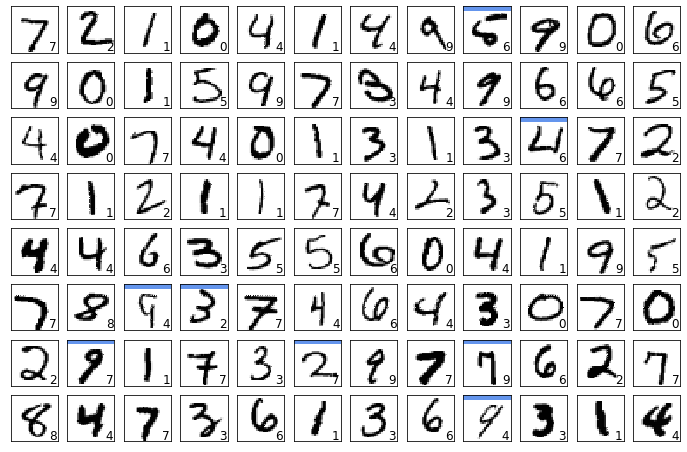

In [9]:
def show_prediction():
    n_show=96
    y=model.predict(x_test)
    plt.figure(2,figsize=(12,8))
    plt.gray()
    for i in range(n_show):
        plt.subplot(8,12,i+1)
        x=x_test[i,:]
        x=x.reshape(28,28)
        plt.pcolor(1-x)
        wk=y[i,:]
        prediction=np.argmax(wk)
        plt.text(22,25.5,'%d'%prediction,fontsize=12)
        if prediction !=np.argmax(y_test[i,:]):
            plt.plot([0,27],[1,1],color='cornflowerblue',linewidth=5)
        plt.xlim(0,27)
        plt.ylim(27,0)
        plt.xticks([],"")
        plt.yticks([],"")

show_prediction()
plt.show()

In [10]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


model = Sequential() 
model.add(Dense(16, input_dim=784, activation='relu')) 
model.add(Dense(10, activation='softmax')) 
model.compile(loss='categorical_crossentropy',
optimizer=Adam(), metrics=['accuracy']) 

startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000,verbose=1, validation_data=(x_test, y_test)) 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 1.4930 - accuracy: 0.5656 - val_loss: 0.8412 - val_accuracy: 0.8124
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6527 - accuracy: 0.8447 - val_loss: 0.5051 - val_accuracy: 0.8747
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.4634 - accuracy: 0.8800 - val_loss: 0.4012 - val_accuracy: 0.8935
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3877 - accuracy: 0.8961 - val_loss: 0.3503 - val_accuracy: 0.9042
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3450 - accuracy: 0.9063 - val_loss: 0.3206 - val_accuracy: 0.9109
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 0.3182 - accuracy: 0.9119 - val_loss: 0.2997 - val_accuracy: 0.9158
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.2992 - accuracy: 0.9166 - val_loss: 0.2891 - val_accuracy: 0.9174
Epoch 8/10
60/60 [==

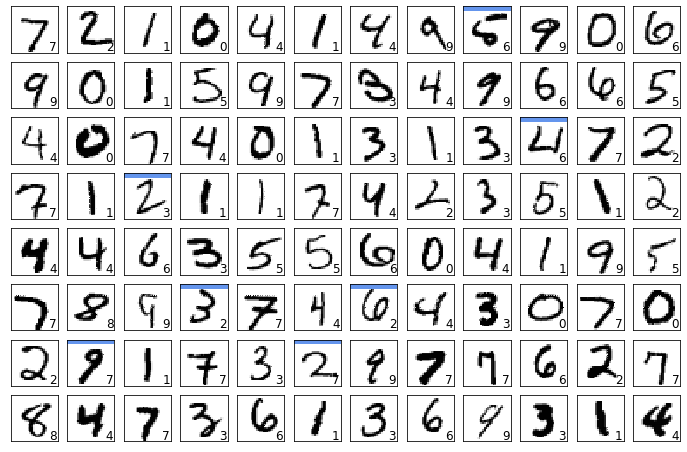

In [11]:
show_prediction()
plt.show()

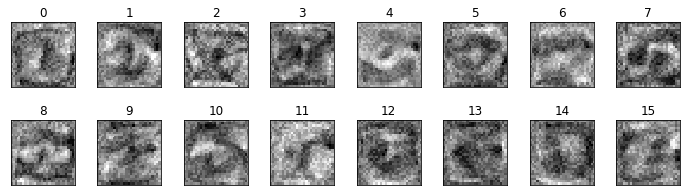

In [12]:
w=model.layers[0].get_weights()[0]
plt.figure(1,figsize=(12,3))
plt.gray()
plt.subplots_adjust(wspace=0.35,hspace=0.5)
for i in range(16):
    plt.subplot(2,8,i+1)
    w1=w[:,i]
    w1=w1.reshape(28,28)
    plt.pcolor(-w1)
    plt.xlim(0,27)
    plt.ylim(27,0)
    plt.xticks([],"")
    plt.yticks([],"")
    plt.title("%d"%i)
plt.show()

In [60]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import np_utils
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = x_train.reshape(60000, 28,28,1) 
x_train = x_train.astype('float32') 
x_train = x_train / 255 
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)


x_test = x_test.reshape(10000, 28,28,1)
x_test = x_test.astype('float32')
x_test = x_test / 255
y_test = np_utils.to_categorical(y_test, num_classes)

In [22]:
id_img=2
myfil1=np.array([[1,1,1],[1,1,1],[-2,-2,-2]],dtype=float)
myfil2=np.array([[-2,1,1],[-2,1,1],[-2,1,1]],dtype=float)

x_img = x_train[id_img, :, :, 0]
img_h=28
img_w=28
x_img=x_img.reshape(img_h,img_w)
out_img1=np.zeros_like(x_img)
out_img2=np.zeros_like(x_img)


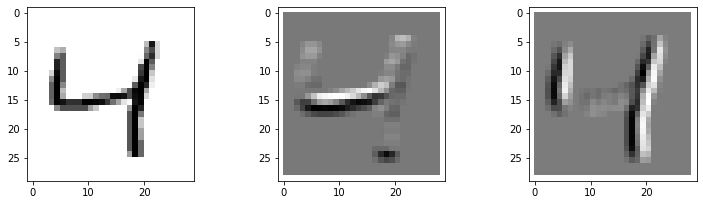

In [23]:
for ih in range(img_h-3):
    for iw in range(img_w-3):
        img_part=x_img[ih:ih+3,iw:iw+3]
        out_img1[ih+1,iw+1]=np.dot(img_part.reshape(-1),myfil1.reshape(-1))
        out_img2[ih+1,iw+1]=np.dot(img_part.reshape(-1),myfil2.reshape(-1))

plt.figure(1,figsize=(12,3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()

plt.subplot(1,3,1)
plt.pcolor(1-x_img)
plt.xlim(-1,29)
plt.ylim(29,-1)

plt.subplot(1,3,2)
plt.pcolor(-out_img1)
plt.xlim(-1,29)
plt.ylim(29,-1)

plt.subplot(1,3,3)
plt.pcolor(-out_img2)
plt.xlim(-1,29)
plt.ylim(29,-1)
plt.show()

In [24]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation,Dropout,Flatten,Dense
from keras.optimizers import Adam
import time

In [18]:
model =Sequential()
model.add(Conv2D(8,(3,3),padding='same',input_shape=(28,28,1),activation='relu'))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
startTime=time.time()
history=model.fit(x_train,y_train,batch_size=1000,epochs=20,verbose=1,validation_data=(x_test,y_test))
score=model.evaluate(x_test,y_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])
print('Computaion time:{0:.3f}sec'.format(time.time()-startTime))

Epoch 1/20
60/60 [==============================] - 6s 103ms/step - loss: 0.8627 - accuracy: 0.7919 - val_loss: 0.3508 - val_accuracy: 0.9016
Epoch 2/20
60/60 [==============================] - 6s 107ms/step - loss: 0.3029 - accuracy: 0.9138 - val_loss: 0.2423 - val_accuracy: 0.9313
Epoch 3/20
60/60 [==============================] - 6s 106ms/step - loss: 0.2258 - accuracy: 0.9363 - val_loss: 0.1915 - val_accuracy: 0.9470
Epoch 4/20
60/60 [==============================] - 7s 115ms/step - loss: 0.1806 - accuracy: 0.9491 - val_loss: 0.1575 - val_accuracy: 0.9554
Epoch 5/20
60/60 [==============================] - 6s 106ms/step - loss: 0.1512 - accuracy: 0.9579 - val_loss: 0.1371 - val_accuracy: 0.9625
Epoch 6/20
60/60 [==============================] - 6s 108ms/step - loss: 0.1292 - accuracy: 0.9643 - val_loss: 0.1198 - val_accuracy: 0.9659
Epoch 7/20
60/60 [==============================] - 6s 108ms/step - loss: 0.1132 - accuracy: 0.9694 - val_loss: 0.1082 - val_accuracy: 0.9696
Epoch 

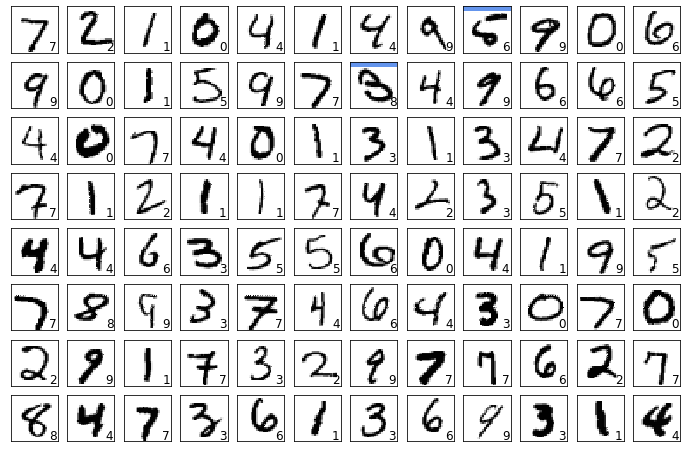

In [26]:
def show_prediction():
    n_show=96
    y=model.predict(x_test)
    plt.figure(2,figsize=(12,8))
    plt.gray()
    for i in range(n_show):
        plt.subplot(8,12,i+1)
        x=x_test[i,:]
        x=x.reshape(28,28)
        plt.pcolor(1-x)
        wk=y[i,:]
        prediction=np.argmax(wk)
        plt.text(22,25.5,'%d'%prediction,fontsize=12)
        if prediction !=np.argmax(y_test[i,:]):
            plt.plot([0,27],[1,1],color='cornflowerblue',linewidth=5)
        plt.xlim(0,27)
        plt.ylim(27,0)
        plt.xticks([],"")
        plt.yticks([],"")

show_prediction()
plt.show()

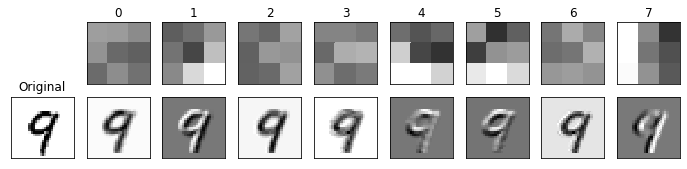

In [28]:
plt.figure(1,figsize=(12,2.5))
plt.gray()
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.subplot(2,9,10)
id_img=12
x_img=x_test[id_img,:,:,0]
img_h=28
img_w=28
x_img=x_img.reshape(img_h,img_w)
plt.pcolor(-x_img)
plt.xlim(0,img_h)
plt.ylim(img_w,0)
plt.xticks([],"")
plt.yticks([],"")
plt.title('Original')
w=model.layers[0].get_weights()[0]
max_w=np.max(w)
min_w=np.min(w)
for i in range(8):
    plt.subplot(2,9,i+2)
    w1=w[:,:,0,i]
    w1=w1.reshape(3,3)
    plt.pcolor(-w1,vmin=min_w,vmax=max_w)
    plt.xlim(0,3)
    plt.ylim(3,0)
    plt.xticks([],"")
    plt.yticks([],"")
    plt.title('%d'%i)
    plt.subplot(2,9,i+11)
    out_img=np.zeros_like(x_img)
    for ih in range(img_h-3):
        for iw in range(img_w-3):
            img_part=x_img[ih:ih+3,iw:iw+3]
            out_img[ih+1,iw+1]=np.dot(img_part.reshape(-1),w1.reshape(-1))
    plt.pcolor(-out_img)
    plt.xlim(0,img_w)
    plt.ylim(img_h,0)
    plt.xticks([],"")
    plt.yticks([],"")
plt.show()

In [33]:
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
import time

In [35]:
model=Sequential()
model.add(Conv2D(16,(3,3),input_shape=(28,28,1),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
startTime=time.time()
history=model.fit(x_train,y_train,batch_size=1000,epochs=20,verbose=1,validation_data=(x_test,y_test))
score=model.evaluate(x_test,y_test,verbose=0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])
print("Computation time:{0:.3f}sec".format(time.time()-startTime))

Epoch 1/20
60/60 [==============================] - 39s 645ms/step - loss: 0.6097 - accuracy: 0.8208 - val_loss: 0.1940 - val_accuracy: 0.9433
Epoch 2/20
60/60 [==============================] - 38s 635ms/step - loss: 0.1939 - accuracy: 0.9412 - val_loss: 0.0999 - val_accuracy: 0.9696
Epoch 3/20
60/60 [==============================] - 38s 637ms/step - loss: 0.1140 - accuracy: 0.9662 - val_loss: 0.0603 - val_accuracy: 0.9806
Epoch 4/20
60/60 [==============================] - 38s 636ms/step - loss: 0.0808 - accuracy: 0.9765 - val_loss: 0.0527 - val_accuracy: 0.9832
Epoch 5/20
60/60 [==============================] - 39s 656ms/step - loss: 0.0666 - accuracy: 0.9794 - val_loss: 0.0410 - val_accuracy: 0.9872
Epoch 6/20
60/60 [==============================] - 40s 667ms/step - loss: 0.0556 - accuracy: 0.9831 - val_loss: 0.0365 - val_accuracy: 0.9879
Epoch 7/20
60/60 [==============================] - 40s 670ms/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0333 - val_accuracy: 0.9880

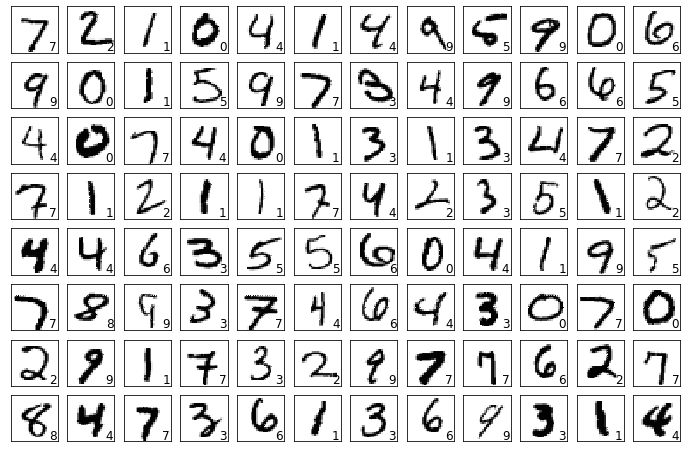

In [36]:
show_prediction()
plt.show()